In [1]:
import pandas as pd 

data_set = pd.read_csv(r'E:\[0]data_set\[0]CIC_IDS_2017\archive\Wednesday-workingHours.pcap_ISCX.csv')

In [2]:
data_set[' Label'].value_counts()

 Label
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64

In [3]:
data_set = data_set[data_set[' Label'] != 'Heartbleed']

In [4]:
data_set[' Label'].value_counts()

 Label
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Name: count, dtype: int64

In [5]:
import numpy as np

data_set.replace([np.inf, -np.inf], np.nan, inplace=True)
data_set.dropna(inplace=True)

In [6]:
data_set[' Label'].value_counts()

 Label
BENIGN              439683
DoS Hulk            230124
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Name: count, dtype: int64

In [7]:
test_set = data_set[data_set[' Label'] == 'BENIGN']

In [8]:
test_set[' Label'].value_counts()

 Label
BENIGN    439683
Name: count, dtype: int64

In [9]:
data_set[' Label'].value_counts()

 Label
BENIGN              439683
DoS Hulk            230124
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Name: count, dtype: int64

In [10]:
test_set = test_set.drop([' Label'],axis=1)
data_set = data_set.drop([' Label'],axis=1)

col = data_set.columns

test_set = test_set.to_numpy()
data_set = data_set.to_numpy()

In [11]:
col

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [15]:
test_set.shape

(439683, 78)

In [14]:
data_set.shape

(691395, 78)

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
import torch

def validate_by_rmse(rmse_vec,thres,label):
    pred = np.asarray([0] * len(rmse_vec))
    idx = np.where(rmse_vec>thres)
    pred[idx] = 1
    cnf_matrix = confusion_matrix(label, pred)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    TPR = (TP/(TP+FN))[1]
    FPR = (FP/(FP+TN))[1]
    print("TPR:",TPR,"|FPR:",FPR)

    return pred

class Normalizer:
    def __init__(self, 
            dim, 
            normer="minmax",
            online_minmax=False): # whether fit_transform online (see Kitsune), *available only for normer="minmax"

        self.dim = dim # feature dimensionality
        self.normer = normer
        if self.normer == 'minmax':
            self.online_minmax = online_minmax
            self.norm_max = [-np.Inf] * self.dim
            self.norm_min = [np.Inf] * self.dim
        else:
            raise NotImplementedError # Implement other Normalizer here
        
    def fit_transform(self,train_feat):
        if self.normer == 'minmax':
            return self._minmax_fit_transform(train_feat)
        else:
            raise NotImplementedError # Implement other Normalizer here

    def transform(self,feat):
        if self.normer == 'minmax':
            return self._minmax_transform(feat)
        else:
            raise NotImplementedError # Implement other Normalizer here

    def restore(self,feat):
        if self.normer == 'minmax':
            return self._minmax_restore(feat)
        else:
            raise NotImplementedError # Implement other Normalizer here
        
    def _minmax_fit_transform(self,train_feat):
        if not self.online_minmax:
            self.norm_min = np.min(train_feat,axis=0)
            self.norm_max = np.max(train_feat,axis=0)
            norm_feat = (train_feat - self.norm_min) / (self.norm_max-self.norm_min+1e-10)
            return norm_feat
        else:
            norm_feat = []
            self.norm_max, self.norm_min = np.asarray(self.norm_max), np.asarray(self.norm_min)
            for i in range(len(train_feat)):
                x = train_feat[i]
                self.norm_max[x>self.norm_max] = x[x>self.norm_max]
                self.norm_min[x<self.norm_min] = x[x<self.norm_min]
                norm_feat.append((x - self.norm_min) / (self.norm_max-self.norm_min+1e-10))
            return np.asarray(norm_feat)

    def _minmax_transform(self, feat):
        norm_feat = (feat - self.norm_min) / (self.norm_max-self.norm_min+1e-10)
        return norm_feat

    def _minmax_restore(self, feat):
        denorm_feat = feat * (self.norm_max-self.norm_min+1e-10) + self.norm_min
        return denorm_feat
    
    # def _olminmax_fit_transform(self, train_feat):
    #     norm_feat = []
    #     for i in range(len(train_feat)):
    #         x = train_feat[i]
    #         self.norm_max[x>self.norm_max] = x[x>self.norm_max]
    #         self.norm_min[x<self.norm_min] = x[x<self.norm_min]
    #         norm_feat.append(x - self.norm_min) / (self.norm_max-self.norm_min+1e-10)
    #     return np.asarray(norm_feat)
    
    # def _olminmax_transform(self, feat):
    #     norm_feat = (feat - self.norm_min) / (self.norm_max-self.norm_min+1e-10)
    #     return norm_feat


""" Deeplog tools """
def deeplogtools_seqformat(model, abnormal_data, num_candidates, index=0):
    import keras.utils.np_utils as np_utils
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X = abnormal_data.copy()
    y, X = X[:,-1], np_utils.to_categorical(X[:,:-1])
    Output = model(torch.from_numpy(X).type(torch.float).to(device))
    TP_idx = []
    for i in range(len(Output)):
        output = Output[i]
        label = y[i]
        predicted = torch.argsort(output)[-num_candidates:]
        if label not in predicted:
            TP_idx.append(i)
    seq_feat = np_utils.to_categorical(abnormal_data[TP_idx])
    feat = seq_feat[index]
    seq = torch.from_numpy(feat[:-1,:]).to(device)
    label = torch.tensor(np.argmax(feat[-1])).unsqueeze(0).to(device)
    return seq,label, abnormal_data[TP_idx][index]

""" Multi LSTM tools """
def multiLSTM_seqformat(test_feat, seq_len = 5, index=0):
    import more_itertools

    X_test = more_itertools.windowed(test_feat[:,:],n=seq_len,step=1)
    X_test = np.asarray(list(X_test))
    y_test = np.asarray(test_feat[seq_len-1:])

    # print("X_test:",X_test.shape,"y_test:",y_test.shape)
    i = index
    interp_feat = y_test[i]
    seq_feat = np.asarray([X_test[i]]) 
    # print("seq_feat:",seq_feat.shape,"interp_feat:",interp_feat.shape)

    return seq_feat, interp_feat

In [17]:
batch = 128
th_per = 0.985

normer = Normalizer(test_set.shape[-1],online_minmax=False) 

In [19]:
train_feat_mine = normer.fit_transform(test_set)

In [20]:
train_feat_mine

array([[1.22161650e-03, 3.19241669e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.94011025e-03, 4.00000003e-06, 4.90335488e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.34377815e-03, 9.13333341e-06, 4.41301939e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.86130072e-01, 6.91666672e-07, 4.90335488e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.09320934e-04, 8.73863341e-03, 2.45167744e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.09320934e-04, 7.91166673e-04, 1.47100646e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [21]:
test_set

array([[8.000000e+01, 3.830800e+04, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [3.890000e+02, 4.790000e+02, 1.100000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.800000e+01, 1.095000e+03, 1.000000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [5.803000e+04, 8.200000e+01, 2.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [5.300000e+01, 1.048635e+06, 6.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [5.300000e+01, 9.493900e+04, 4.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [22]:
check_slice = pd.DataFrame(test_set,columns=col)
check_slice

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,80.0,38308.0,1.0,1.0,6.0,6.0,6.0,6.0,6.000000,0.000000,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,389.0,479.0,11.0,5.0,172.0,326.0,79.0,0.0,15.636364,31.449238,...,4.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,88.0,1095.0,10.0,6.0,3150.0,3150.0,1575.0,0.0,315.000000,632.561635,...,3.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,389.0,15206.0,17.0,12.0,3452.0,6660.0,1313.0,0.0,203.058823,425.778474,...,10.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,88.0,1092.0,9.0,6.0,3150.0,3152.0,1575.0,0.0,350.000000,694.509719,...,2.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439678,53.0,32215.0,4.0,2.0,112.0,152.0,28.0,28.0,28.000000,0.000000,...,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439679,53.0,324.0,2.0,2.0,84.0,362.0,42.0,42.0,42.000000,0.000000,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439680,58030.0,82.0,2.0,1.0,31.0,6.0,31.0,0.0,15.500000,21.920310,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439681,53.0,1048635.0,6.0,2.0,192.0,256.0,32.0,32.0,32.000000,0.000000,...,5.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
check_train = pd.DataFrame(train_feat_mine,columns=col)
check_train

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.001222,3.192417e-04,0.000000,0.000004,0.000005,9.569378e-09,0.000242,0.002906,0.001293,0.000000,...,0.000000,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.005940,4.000000e-06,0.000049,0.000018,0.000141,5.199362e-07,0.003183,0.000000,0.003369,0.004892,...,0.000020,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001344,9.133333e-06,0.000044,0.000022,0.002573,5.023923e-06,0.063457,0.000000,0.067877,0.098389,...,0.000015,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.005940,1.267250e-04,0.000078,0.000044,0.002820,1.062201e-05,0.052901,0.000000,0.043756,0.066226,...,0.000051,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001344,9.108333e-06,0.000039,0.000022,0.002573,5.027113e-06,0.063457,0.000000,0.075419,0.108024,...,0.000010,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439678,0.000809,2.684667e-04,0.000015,0.000007,0.000091,2.424242e-07,0.001128,0.013559,0.006033,0.000000,...,0.000015,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439679,0.000809,2.708333e-06,0.000005,0.000007,0.000069,5.773525e-07,0.001692,0.020339,0.009050,0.000000,...,0.000005,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439680,0.886130,6.916667e-07,0.000005,0.000004,0.000025,9.569378e-09,0.001249,0.000000,0.003340,0.003409,...,0.000000,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439681,0.000809,8.738633e-03,0.000025,0.000007,0.000157,4.082935e-07,0.001289,0.015496,0.006895,0.000000,...,0.000025,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def se2rmse(a):
    return torch.sqrt(sum(a.t())/a.shape[1])


#batch_size = 128 
lr = 1e-3 
weight_decay = 1e-6
epoches = 5 

class autoencoder(nn.Module):
    def __init__(self, feature_size):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(feature_size, int(feature_size*0.75)),
                                     nn.ReLU(True),
                                     nn.Linear(int(feature_size*0.75), int(feature_size*0.5)),
                                     nn.ReLU(True),
                                     nn.Linear(int(feature_size*0.5),int(feature_size*0.25)),
                                     nn.ReLU(True),
                                     nn.Linear(int(feature_size*0.25),int(feature_size*0.1)))

        self.decoder = nn.Sequential(nn.Linear(int(feature_size*0.1),int(feature_size*0.25)),
                                     nn.ReLU(True),
                                     nn.Linear(int(feature_size*0.25),int(feature_size*0.5)),
                                     nn.ReLU(True),
                                     nn.Linear(int(feature_size*0.5),int(feature_size*0.75)),
                                     nn.ReLU(True),
                                     nn.Linear(int(feature_size*0.75),int(feature_size)),
                                     )
    
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode
    
criterion = nn.MSELoss()
getMSEvec = nn.MSELoss(reduction='none')


def train(X_train,feature_size,th_per, batch_size):
    model = autoencoder(feature_size).to(device)
    optimizier = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()

    X_train = torch.from_numpy(X_train).type(torch.float)    
    if torch.cuda.is_available(): X_train = X_train.cuda()
    torch_dataset = Data.TensorDataset(X_train, X_train)
    loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    for epoch in range(epoches):
        for step, (batch_x, batch_y) in enumerate(loader):
            output = model(batch_x)
            loss = criterion(output, batch_y)
            optimizier.zero_grad()
            loss.backward()
            optimizier.step()
            if step % 10 == 0 :
                print('epoch:{}/{}'.format(epoch,step), '|Loss:', loss.item())
    
    model.eval()
    output = model(X_train)
    mse_vec = getMSEvec(output,X_train)
    rmse_vec = se2rmse(mse_vec).cpu().data.numpy()

    print("max AD score",max(rmse_vec))
    thres = max(rmse_vec)
    rmse_vec.sort()
    pctg = 0.9999   # 99% percentage for threshold selection
    thres = rmse_vec[int(len(rmse_vec)*pctg)]
    print("thres:",thres)

    return model, thres
    
@torch.no_grad()
def test(model, thres, X_test):
    model.eval()
    X_test = torch.from_numpy(X_test).type(torch.float)    
    X_test = X_test.cuda()
    output = model(X_test)
    mse_vec = getMSEvec(output,X_test)
    rmse_vec = se2rmse(mse_vec).cpu().data.numpy()
    # idx_mal = np.where(rmse_vec>thres)
    # idx_ben = np.where(rmse_vec<=thres)
    # print(len(rmse_vec[idx_ben]),len(rmse_vec[idx_mal]))
    return rmse_vec

def test_plot(X_test, rmse_vec, thres):
    plt.scatter(np.linspace(0,len(X_test)-1,len(X_test)),rmse_vec,s=2)
    plt.plot(np.linspace(0,len(X_test)-1,len(X_test)),[thres]*len(X_test),c='black')
    plt.show()


In [26]:
batch = 128
th_per = 0.985

model, thres = train(train_feat_mine, train_feat_mine.shape[-1],th_per,batch)

epoch:0/0 |Loss: 0.0366278700530529
epoch:0/10 |Loss: 0.026937559247016907
epoch:0/20 |Loss: 0.021844301372766495
epoch:0/30 |Loss: 0.01954091154038906
epoch:0/40 |Loss: 0.018447231501340866
epoch:0/50 |Loss: 0.01315491832792759
epoch:0/60 |Loss: 0.013172412291169167
epoch:0/70 |Loss: 0.013994752429425716
epoch:0/80 |Loss: 0.013055171817541122
epoch:0/90 |Loss: 0.014117994345724583
epoch:0/100 |Loss: 0.01237508375197649
epoch:0/110 |Loss: 0.00976841151714325
epoch:0/120 |Loss: 0.009078450500965118
epoch:0/130 |Loss: 0.006571111269295216
epoch:0/140 |Loss: 0.007084394805133343
epoch:0/150 |Loss: 0.005853230599313974
epoch:0/160 |Loss: 0.0057461136020720005
epoch:0/170 |Loss: 0.006649274379014969
epoch:0/180 |Loss: 0.004874846898019314
epoch:0/190 |Loss: 0.006135111674666405
epoch:0/200 |Loss: 0.005633355118334293
epoch:0/210 |Loss: 0.0030597008299082518
epoch:0/220 |Loss: 0.00505602452903986
epoch:0/230 |Loss: 0.004987499210983515
epoch:0/240 |Loss: 0.0041558872908353806
epoch:0/250 |Lo

In [27]:
anomaly = Normalizer(data_set.shape[-1],online_minmax=False) 

In [29]:
test_feat_mine = anomaly.fit_transform(data_set)

In [30]:
data_set

array([[8.000000e+01, 3.830800e+04, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [3.890000e+02, 4.790000e+02, 1.100000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.800000e+01, 1.095000e+03, 1.000000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [5.803000e+04, 8.200000e+01, 2.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [5.300000e+01, 1.048635e+06, 6.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [5.300000e+01, 9.493900e+04, 4.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [31]:
test_feat_mine

array([[1.22161650e-03, 3.19241669e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.94011025e-03, 4.00000003e-06, 4.90335488e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.34377815e-03, 9.13333341e-06, 4.41301939e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.86130072e-01, 6.91666672e-07, 4.90335488e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.09320934e-04, 8.73863341e-03, 2.45167744e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.09320934e-04, 7.91166673e-04, 1.47100646e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [32]:
test_mine = normer.transform(data_set)

In [33]:
rmse_vec = test(model,thres,test_mine)

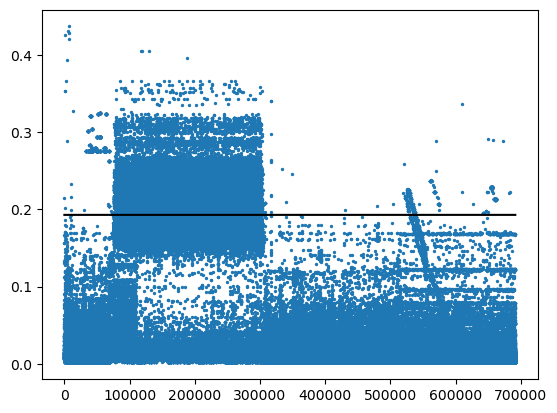

In [34]:
test_plot(test_mine, rmse_vec, thres)